In [1]:
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO

2024-09-04 11:25:23.399967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 11:25:23.400041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 11:25:23.470184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 11:25:23.610535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 11:25:25.116639: W tensorflow/compiler/tf2

In [2]:
import sys
sys.path.append("../")
from magpie import realsense_wrapper as real
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
rsc = real.RealSense()
rsc.initConnection()

In [4]:
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [5]:
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

In [ ]:
# url = "test.jpg"
# image = Image.open(url).convert("RGB")
# url = "image.png"

In [6]:
p, rgbd_image = rsc.getPCD()
# p, rgbd_image = rsc.getPCD(adjust_extrinsics=True)
image = np.array(rgbd_image.color)
img = Image.fromarray(image)
texts = [["a photo of a yellow block"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)


In [11]:
W = img.size[0]
H = img.size[1]
target_sizes = torch.Tensor([[W, W]])

TypeError: 'int' object is not subscriptable

In [14]:
target_sizes = torch.Tensor([[max(W,H), max(W,H)]])
target_sizes


tensor([[1280., 1280.]])

In [18]:

# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
boxes = [b.tolist() + [s] for b, s in zip(boxes, scores.tolist())]


Detected a photo of a yellow block with confidence 0.566 at location [614.29, 230.63, 670.94, 287.75]
Detected a photo of a yellow block with confidence 0.244 at location [590.6, 344.12, 647.12, 395.21]
Detected a photo of a yellow block with confidence 0.358 at location [573.01, 447.89, 626.46, 499.57]


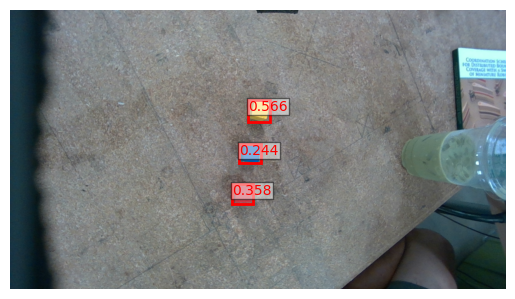

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO

# Bounding box coordinates and confidence levels
# boxes = [
#     [341.67, 23.39, 642.32, 371.35, 0.614],
#     [6.75, 51.96, 326.62, 473.13, 0.665]
# ]

# visualized_image = unnormalized_image.copy()

img = image
# img = visualized_image

# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(img)

# Add bounding boxes
for box in boxes:
    x1, y1, x2, y2, confidence = box
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1, f'{confidence:.3f}', color='red', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

plt.axis('off')
plt.show()

In [2]:
import sys
sys.path.append("../")
# from magpie.perception.label_owlvit import LabelOWLViT
from magpie.perception.label_owlv2 import LabelOWLv2
# path = "google/owlvit-base-patch32"
# label_vit = LabelOWLViT(pth=path, topk=3)
label_vit = LabelOWLv2(topk=3)

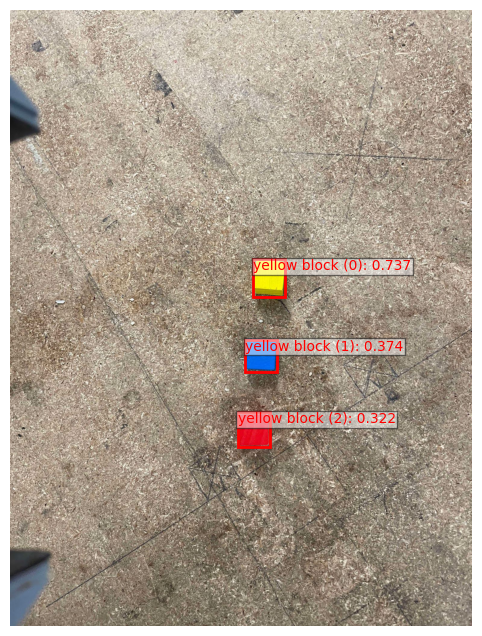

In [3]:
import numpy as np
from PIL import Image
image = Image.open("test.jpg").convert("RGB")
label_vit.set_threshold(0.001)
image = np.array(image)
queries = ["a photo of a yellow block"]
abbrevq = ["yellow block"]
bboxes, uboxes = label_vit.label(image, queries, abbrevq, plot=True, topk=True)


In [5]:
label_vit.sorted_labeled_boxes_coords[:3]

[(array([808.78564, 828.45197, 913.578  , 952.09625], dtype=float32), 0),
 (array([ 781.1911, 1095.1906,  886.8322, 1203.2418], dtype=float32), 0),
 (array([ 755.9107 , 1337.5481 ,  862.88544, 1452.7532 ], dtype=float32), 0)]

In [6]:
import sys
sys.path.append("../")
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit1 = LabelOWLViT(pth=path, topk=3)

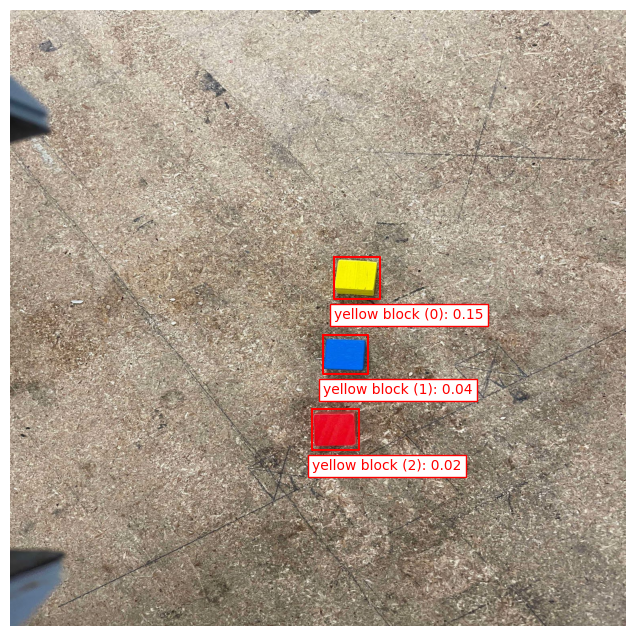

In [7]:
import numpy as np
from PIL import Image
image = Image.open("test.jpg").convert("RGB")
label_vit.set_threshold(0.001)
image = np.array(image)
queries = ["a photo of a yellow block"]
abbrevq = ["yellow block"]
bboxes, uboxes = label_vit1.label(image, queries, abbrevq, plot=True, topk=True)


In [8]:
label_vit1.sorted_labeled_boxes_coords[:3]

[(array([808.1278038 , 821.32295227, 922.95166397, 960.20353699]), 0),
 (array([ 781.16195869, 1081.80727768,  893.65524101, 1209.71176529]), 0),
 (array([ 753.87039185, 1327.1173172 ,  869.4994812 , 1461.44908905]), 0)]